In [7]:
#perparing to work with text data
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\myyuv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myyuv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Input

In [2]:
#load data form csv file
data = pd.read_csv('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\merged_data_file.csv')
data.head(5)

,Unnamed: 0.1,Category,Description,Title,Unnamed: 0,Video Id,file
0,0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,0,i9E_Blai8vk,Collected_data_raw1.csv
1,1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,1,UBvJKs9eW3I,Collected_data_raw1.csv
2,2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,2,jeIQ_Z35HZ4,Collected_data_raw1.csv
3,3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",3,EthqIhPtd2I,Collected_data_raw1.csv
4,4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,4,X0F0Dh8ut3U,Collected_data_raw1.csv


In [3]:
data.shape

(29245, 7)

In [4]:
#removing unnecessary columns,handling missing values
del data['Unnamed: 0']
del data['Unnamed: 0.1']
del data['file']
data.isnull().sum()
df = data[data['Description'].notnull()]
df.head()

,Category,Description,Title,Video Id
0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,i9E_Blai8vk
1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,UBvJKs9eW3I
2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,jeIQ_Z35HZ4
3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",EthqIhPtd2I
4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,X0F0Dh8ut3U


In [6]:
#removing degits,specific characters 
df['Category'] = df['Category'].str.replace(r'\d+','')
df['Description'] = df['Description'].str.replace(r'\d+','')
df['Title'] = df['Title'].str.replace(r'\d+','')
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['Title'] = df['Title'].str.replace(char, ' ')
    df['Description'] = df['Description'].str.replace(char, ' ')
    df['Category'] = df['Category'].str.replace(char, ' ')

In [7]:
removing emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
for i, row in df.iterrows():
    text_t = remove_emoji(row['Title'])
    text_d = remove_emoji(row['Description'])
    df.at[i,'Title']= text_t
    df.at[i,'Description'] = text_d

In [8]:
#retaing meaninful words in the textdata
for i, row in df.iterrows():
    text_t = ' '.join([w for w in row['Title'].split() if wordnet.synsets(w)])
    df.at[i,'Title'] = text_t
    text_d = ' '.join([w for w in row['Description'].split() if wordnet.synsets(w)])
    df.at[i,'Description'] = text_d

In [9]:
#prepare the textdata for modeling
for i, row in df.iterrows():
    word_list_t = row['Title'].lower().split() 
    filtered_words = [word for word in word_list_t if word not in stopwords.words('english')]
    text_t = ' '.join(filtered_words)
    df.at[i,'Title']= text_t
    word_list_d = row['Description'].lower().split() 
    filtered_words = [word for word in word_list_d if word not in stopwords.words('english')]
    text_d = ' '.join(filtered_words)
    df.at[i,'Description'] = text_d

In [10]:
df.Category.value_counts()

Category
sports                    2984
nature                    2526
science and technology    2499
travel                    2431
food                      2318
art and music             2167
manufacturing             1932
adventure                 1575
history                   1298
Name: count, dtype: int64

In [11]:
# Tokenization
df['descriptions_token'] = df['Description'].apply(lambda x: x.split())

In [17]:
#extract relevant tokens for further processing 
def token_check(x,model):
  """
  1.Check if the token exists in the word2vec model vocab. 
  2.Check if the length of the token is greater than 3 
  """
  token_list=[]
  for i in x:
      if len(i) > 3 and i in model.key_to_index:
          token_list.append(i)
      else:
          continue
  return token_list

In [18]:
#list of tokens using word embedding model
def word_vector(tokens,size,model):

  """Averaging the word vectors"""
  
  vec = np.zeros(size).reshape((1, size))
  count = 0
  for word in tokens:
    vec += model[word].reshape((1, size))
    count += 1.
  if count != 0:
      vec /= count
  return vec

In [19]:
from gensim.models import Word2Vec,KeyedVectors

In [29]:
#Load the word2vec pre trained Model to get the word embeddings for each token
model = KeyedVectors.load_word2vec_format('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\GoogleNews-vectors-negative300.bin.gz',binary=True,limit=1000000)

df['descriptions_token'] = df['descriptions_token'].apply(lambda x:token_check(x,model))

In [30]:
df.reset_index(drop=True, inplace=True)

wordvec_arrays = np.zeros((len(df.descriptions_token),300))

for i in range(len(df.descriptions_token)):
  wordvec_arrays[i,:] = word_vector(df.descriptions_token[i],300,model)

vectorized_df = pd.DataFrame(wordvec_arrays)

In [31]:
target_one_hot_encoded = pd.get_dummies(df['Category'])

In [32]:
target_one_hot_encoded.head()

,adventure,art and music,food,history,manufacturing,nature,science and technology,sports,travel
0,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,True


In [33]:
dataset = pd.merge(vectorized_df,target_one_hot_encoded,left_index=True, right_index=True)

In [34]:
dataset_shuffled = dataset.reindex(np.random.permutation(dataset.index))

In [35]:
#splitting of data
from sklearn.model_selection import train_test_split

target=['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']
X = dataset_shuffled.loc[:,~dataset_shuffled.columns.isin(target)]
y = dataset_shuffled.loc[:,dataset_shuffled.columns.isin(target)]

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75,test_size=0.25,random_state=101)

In [36]:
from keras import models
from keras import layers
from keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras import backend as K
from matplotlib import pyplot as plt

#perform classification tasks,particular multi-class classification 
def NN_arch1(lrate=0.0001):
    model = models.Sequential()
    model.add(layers.Dense(300,input_dim = 300, activation='relu'))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(4,activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    opt = keras.optimizers.Adam(lr=lrate)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

def NN_arch2(lrate=0.0001):
    model = models.Sequential()
    model.add(layers.Dense(300,input_dim = 300, activation='relu'))
    model.add(layers.Dense(5,activation='sigmoid'))
    model.add(Dropout(0.20))
    model.add(layers.Dense(6,activation='relu'))
    model.add(Dropout(0.10))
    #model.add(layers.Dense(4,activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    opt = keras.optimizers.Adam(lr=lrate)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model
#traing the model on the traning data
def model_fit(model,X_train,y_train,X_test,y_test,epoch_val=50):
    callbacks = EarlyStopping(monitor='val_loss',mode='min',patience=3)
    model.fit(X_train, y_train, epochs=epoch_val,batch_size=50)
    val_loss, val_acc = model.evaluate(X_test,y_test)
    print("val_loss, val_acc",val_loss, val_acc)
    return val_loss,val_acc
#create a plot that visualizes the traning and validation metrics
def history_plot(history):
    """ history plot """
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.figure(figsize=(5,3))

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    #Visualize accuracy history
    plt.plot(epoch_count, training_acc, 'r--')
    plt.plot(epoch_count, test_acc, 'b-')
    plt.legend(['Training acc', 'Test acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.show();

In [37]:
#model_NN = NN_arch1(0.00001)
#val_loss,val_acc = model_fit(model_NN,X_train,y_train,X_test,y_test,epoch_val=100)

#history = model_NN.fit(X_train,y_train,epochs=100,verbose=0,validation_data=(X_test, y_test)) 
#history_plot(history)

Epoch 1/100
148/148 [==============================] - 1s 4ms/step - loss: 0.6031 - accuracy: 0.1291 - val_loss: 0.5107 - val_accuracy: 0.1378
Epoch 2/100
148/148 [==============================] - 0s 3ms/step - loss: 0.4503 - accuracy: 0.1539 - val_loss: 0.3716 - val_accuracy: 0.1924
Epoch 3/100
148/148 [==============================] - 0s 3ms/step - loss: 0.3687 - accuracy: 0.1708 - val_loss: 0.3326 - val_accuracy: 0.2023
Epoch 4/100
148/148 [==============================] - 0s 3ms/step - loss: 0.3429 - accuracy: 0.2002 - val_loss: 0.3177 - val_accuracy: 0.2522
Epoch 5/100
148/148 [==============================] - 0s 3ms/step - loss: 0.3300 - accuracy: 0.2777 - val_loss: 0.3079 - val_accuracy: 0.3675
Epoch 6/100
148/148 [==============================] - 0s 3ms/step - loss: 0.3239 - accuracy: 0.2931 - val_loss: 0.3014 - val_accuracy: 0.3726
Epoch 7/100
148/148 [==============================] - 0s 3ms/step - loss: 0.3149 - accuracy: 0.3070 - val_loss: 0.2886 - val_accuracy: 0.4306

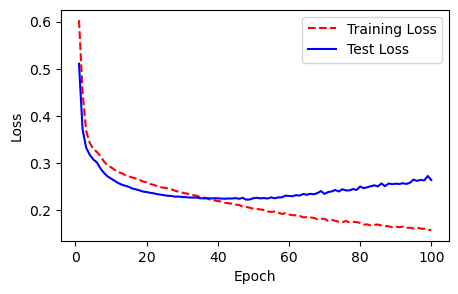

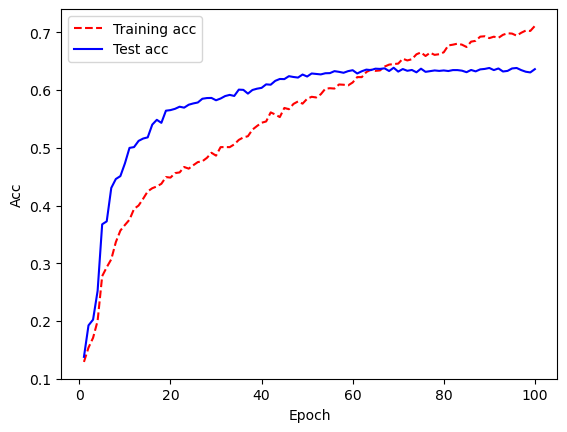

In [38]:
#create model
model_NN = NN_arch2(0.0009)
#val_loss,val_acc = model_fit(model_NN,100)
history = model_NN.fit(X_train,y_train,epochs=100,verbose=1,batch_size=100,validation_data=(X_test, y_test)) 
history_plot(history)

In [39]:
#save the model
model_NN.save('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\model_text_categorize.h5')

C:\Users\myyuv\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\model_text_categorize.h5')

In [4]:
#Load the word2vec pre trained Model to get the word embeddings for each token
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\GoogleNews-vectors-negative300.bin.gz',binary=True,limit=1000000)

In [5]:
def clean_description_text(description):
  description = description.replace(r'\d+','')
  spec_chars = ["!",'"',"#","%","&","'","(",")",
                "*","+",",","-",".","/",":",";","<",
                "=",">","?","@","[","\\","]","^","_",
                "`","{","|","}","~","–"]
  for char in spec_chars:
      description = description.replace(char, ' ')

  word_list_t = description.lower().split() 
 
  filtered_words = [word for word in word_list_t if word not in stopwords.words('english')]
  text = ' '.join(filtered_words)
  return text

In [9]:
import pandas as pd


data = pd.read_csv('C:\\Users\\myyuv\\Documents\\pirapanth\\model\\model2\\merged_data_file.csv')
df = data[data['Description'].notnull()]
def token_check(x,vector_model):
  """
  1.Check if the token exists in the word2vec model vocab. 
  2.Check if the length of the token is greater than 3 
  """
  token_list=[]
  for i in x:
      if len(i) > 3 and i in vector_model.key_to_index:
          token_list.append(i)
      else:
          continue
  return token_list

In [10]:
def word_vector(tokens,size,vector_model):

  """Averaging the word vectors"""
  
  vec = np.zeros(size).reshape((1, size))
  count = 0
  for word in tokens:
    vec += vector_model[word].reshape((1, size))
    count += 1.
  if count != 0:
      vec /= count
  return vec

In [13]:
#test the model

description = 'cricket '

clean_description = clean_description_text(description)
description_tokens = list(clean_description.split(" "))
description_tokens_filtered = token_check(description_tokens,model)

_arrays = np.zeros((1, 300))
_arrays[0,:] = word_vector(description_tokens_filtered,300,model)
vectorized_array = pd.DataFrame(_arrays)

pred = loaded_model.predict([vectorized_array.iloc[:,0:300]])

value = np.argmax(pred,axis=-1)
labels = ['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']

print("Predicted Label : " , labels[value.item()])  

1/1 [==============================] - 0s 89ms/step
Predicted Label :  sports
